# Notebook 1 — Dataset Preparation & EDA

**Goal:** curate the AneRBC-I multimodal dataset, perform exploratory data analysis,
pre-process images offline, and create patient-level train/val/test splits.

**Outputs:**
- `transformedDataset/curated_dataset.csv`
- `transformedDataset/processed_images/*.pt` (offline-preprocessed image tensors)
- `transformedDataset/train_split.csv`, `val_split.csv`, `test_split.csv`

In [22]:
import os, sys, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

# --- Project paths (notebook lives at Code/Fusion_Model/) ---
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('__file__'))
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..', '..'))
DATASET_DIR  = os.path.join(PROJECT_ROOT, 'AneRBC_dataset', 'AneRBC-I')
TRANSFORMED   = os.path.join(NOTEBOOK_DIR, 'transformedDataset')
PROCESSED_IMG = os.path.join(TRANSFORMED, 'processed_images')

os.makedirs(PROCESSED_IMG, exist_ok=True)

print(f'PROJECT_ROOT : {PROJECT_ROOT}')
print(f'DATASET_DIR  : {DATASET_DIR}')
print(f'TRANSFORMED  : {TRANSFORMED}')

PROJECT_ROOT : /Users/kiran/Downloads/fyp
DATASET_DIR  : /Users/kiran/Downloads/fyp/AneRBC_dataset/AneRBC-I
TRANSFORMED  : /Users/kiran/Downloads/fyp/Code/Fusion_Model/transformedDataset


## Step 1 — Load Source CSV

In [23]:
source_csv = os.path.join(TRANSFORMED, 'AneRBC_I_Full_Clinical_Data.csv')
raw = pd.read_csv(source_csv)
print(f'Raw shape: {raw.shape}')
raw.head()

Raw shape: (1000, 23)


,File_Name,Cohort,WBC,WBC_abnormal,RBC,RBC_abnormal,HGB,HGB_abnormal,HCT,HCT_abnormal,...,MCH_abnormal,MCHC,MCHC_abnormal,PLT,PLT_abnormal,MPV,MPV_abnormal,RDW_CV,RDW_CV_abnormal,Anemia_Category
0,001_a.txt,Anemic,8.49,0,4.37,0,10.1,1,29.9,1,...,1,33.8,0,376.0,0,11.2,1,NaN,0,1
1,002_a.txt,Anemic,9.16,0,4.94,0,12.3,0,35.6,0,...,1,34.6,0,232.0,0,10.1,0,NaN,0,1
2,003_a.txt,Anemic,21.29,1,4.46,1,10.8,1,32.9,1,...,0,32.8,0,501.0,1,8.0,0,14.9,1,1
3,004_a.txt,Anemic,1.95,1,2.10,1,5.9,1,17.5,1,...,0,33.7,0,106.0,1,NaN,0,21.2,1,2
4,005_a.txt,Anemic,11.87,0,4.85,0,7.7,1,27.9,0,...,1,27.6,1,803.0,1,NaN,0,NaN,0,1


In [24]:
# Keep only required columns: File_Name, 10 numeric CBC features, Anemia_Category
CBC_FEATURES = ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT', 'MPV', 'RDW_CV']
KEEP_COLS = ['File_Name'] + CBC_FEATURES + ['Anemia_Category']

df = raw[KEEP_COLS].copy()
df.rename(columns={'Anemia_Category': 'final_class'}, inplace=True)
print(f'Curated shape: {df.shape}')
df.head()

Curated shape: (1000, 12)


,File_Name,WBC,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,MPV,RDW_CV,final_class
0,001_a.txt,8.49,4.37,10.1,29.9,68.4,23.1,33.8,376.0,11.2,NaN,1
1,002_a.txt,9.16,4.94,12.3,35.6,72.1,24.9,34.6,232.0,10.1,NaN,1
2,003_a.txt,21.29,4.46,10.8,32.9,73.8,24.2,32.8,501.0,8.0,14.9,1
3,004_a.txt,1.95,2.10,5.9,17.5,83.3,28.1,33.7,106.0,NaN,21.2,2
4,005_a.txt,11.87,4.85,7.7,27.9,57.5,15.9,27.6,803.0,NaN,NaN,1


## Step 2 — Derive `patient_id`

In [25]:
df['patient_id'] = df['File_Name'].str.replace('.txt', '', regex=False)
print(f'Unique patients: {df["patient_id"].nunique()}')
df[['File_Name', 'patient_id']].head()

Unique patients: 1000


,File_Name,patient_id
0,001_a.txt,001_a
1,002_a.txt,002_a
2,003_a.txt,003_a
3,004_a.txt,004_a
4,005_a.txt,005_a


## Step 3 — Map `image_path` & validate

In [26]:
def map_image_path(patient_id: str) -> str:
    """Map patient_id (e.g. '001_a') to the relative image path."""
    suffix = patient_id.split('_')[-1]
    if suffix == 'a':
        subdir = 'Anemic_individuals'
    else:
        subdir = 'Healthy_individuals'
    return os.path.join(
        'AneRBC_dataset', 'AneRBC-I', subdir, 'Original_images', f'{patient_id}.png'
    )

df['image_path'] = df['patient_id'].apply(map_image_path)

# Validate every path exists
missing = []
for p in df['image_path']:
    full = os.path.join(PROJECT_ROOT, p)
    if not os.path.isfile(full):
        missing.append(p)

if missing:
    print(f'WARNING: {len(missing)} images missing!')
    for m in missing[:10]:
        print(f'  {m}')
else:
    print(f'All {len(df)} image paths validated successfully.')

All 1000 image paths validated successfully.


## Step 4 — Missing Value Summary

In [27]:
missing_counts = df[CBC_FEATURES].isnull().sum()
missing_pct = (missing_counts / len(df) * 100).round(1)
missing_summary = pd.DataFrame({'missing_count': missing_counts, 'missing_%': missing_pct})
print('Missing values per CBC feature:')
print(missing_summary[missing_summary['missing_count'] > 0])
print(f'\nTotal rows: {len(df)}')

Missing values per CBC feature:
        missing_count  missing_%
RBC                 1        0.1
HGB                 1        0.1
HCT                 1        0.1
MCHC                9        0.9
PLT                 4        0.4
MPV               303       30.3
RDW_CV            571       57.1

Total rows: 1000


## Step 5 — Offline Image Preprocessing

Pipeline: Load PNG → Resize shortest side to 256 (bicubic + antialias) → Tensor [0,1] → Save `.pt`

Note: normalization is now moved to the dataset loader (after augmentation) to preserve image information offline.

In [28]:
from torchvision.transforms import InterpolationMode

OFFLINE_IMAGE_TRANSFORM = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BICUBIC, antialias=True),
    T.ToTensor(),  # keep unnormalized in [0, 1]
])

# Set True once to regenerate tensors if old files were created with the previous normalized 224x224 pipeline
FORCE_REBUILD_PROCESSED = True

processed_paths = []
processed_count = 0

for i, row in df.iterrows():
    src = os.path.join(PROJECT_ROOT, row['image_path'])
    dst_rel = os.path.join(
        'Code', 'Fusion_Model', 'transformedDataset', 'processed_images',
        f"{row['patient_id']}.pt"
    )
    dst_abs = os.path.join(PROJECT_ROOT, dst_rel)
    processed_paths.append(dst_rel)

    if os.path.exists(dst_abs) and not FORCE_REBUILD_PROCESSED:
        continue

    img = Image.open(src).convert('RGB')
    tensor = OFFLINE_IMAGE_TRANSFORM(img)  # (3, 256, 256), [0, 1]
    torch.save(tensor, dst_abs)
    processed_count += 1

    if (i + 1) % 200 == 0:
        print(f'  Processed {i + 1}/{len(df)} images')

df['processed_image_path'] = processed_paths
print(f'Done. {processed_count} files written, {len(processed_paths)} paths assigned.')

  Processed 200/1000 images
  Processed 400/1000 images
  Processed 600/1000 images
  Processed 800/1000 images
  Processed 1000/1000 images
Done. 1000 files written, 1000 paths assigned.


### Verification — display sample original vs offline-processed images

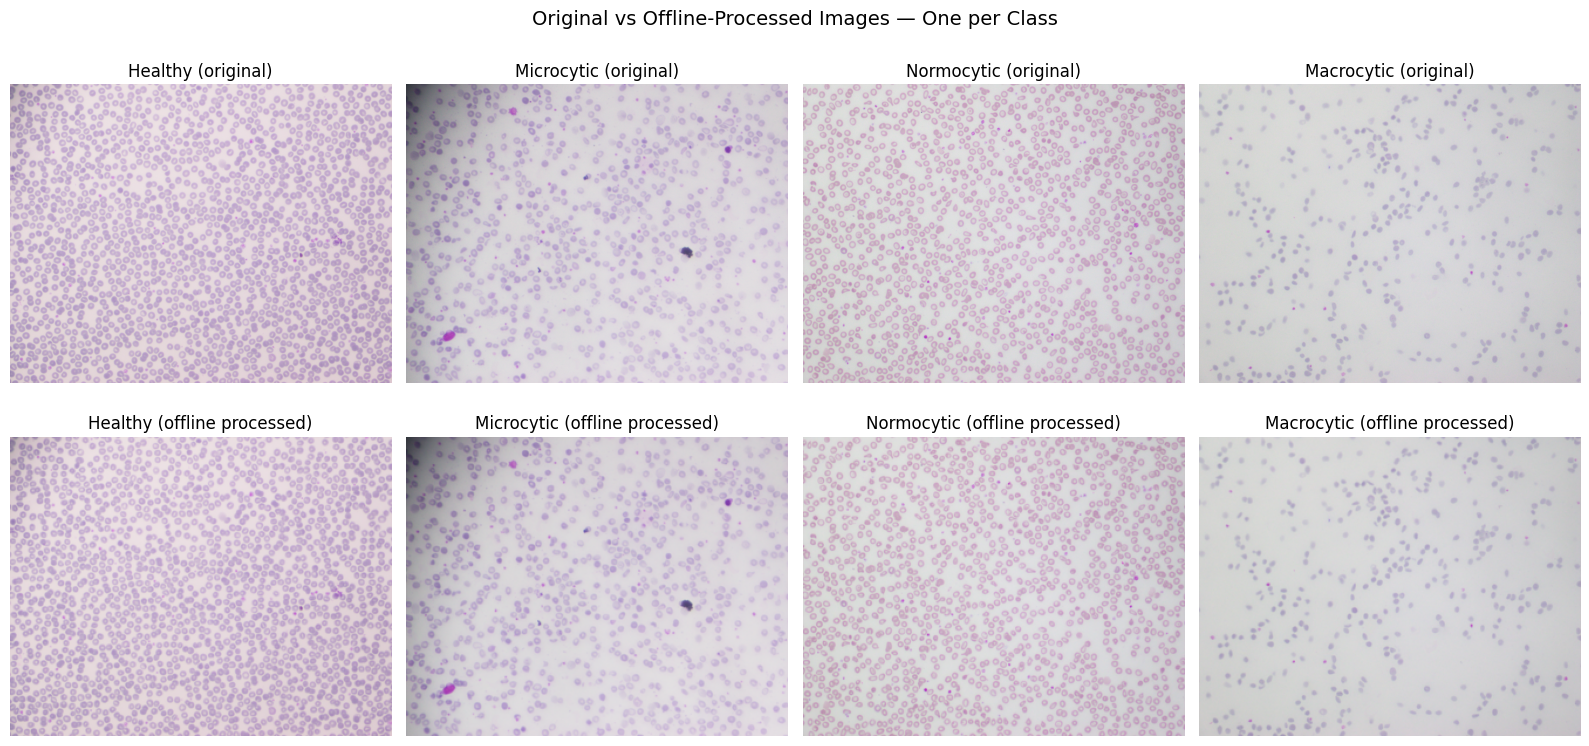

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
class_names = ['Healthy', 'Microcytic', 'Normocytic', 'Macrocytic']

samples = (
    curated.groupby('final_class', group_keys=False)
    .sample(n=1, random_state=42)
    .sort_values('final_class')
)

for _, row in samples.iterrows():
    cls = int(row['final_class'])

    # Original image
    orig = Image.open(os.path.join(PROJECT_ROOT, row['image_path']))
    axes[0, cls].imshow(orig)
    axes[0, cls].set_title(f'{class_names[cls]} (original)')
    axes[0, cls].axis('off')

    # Offline-processed tensor (unnormalized, resized shortest side to 256)
    tensor = torch.load(os.path.join(PROJECT_ROOT, row['processed_image_path']), weights_only=True)
    axes[1, cls].imshow(tensor.permute(1, 2, 0).numpy())
    axes[1, cls].set_title(f'{class_names[cls]} (offline processed)')
    axes[1, cls].axis('off')

plt.suptitle('Original vs Offline-Processed Images — One per Class', fontsize=14)
plt.tight_layout()
plt.show()

## Step 6 — Save Curated CSV

In [30]:
curated_cols = ['patient_id', 'image_path', 'processed_image_path'] + CBC_FEATURES + ['final_class']
curated = df[curated_cols].copy()
curated_path = os.path.join(TRANSFORMED, 'curated_dataset.csv')
curated.to_csv(curated_path, index=False)
print(f'Saved curated_dataset.csv  →  {curated.shape[0]} rows, {curated.shape[1]} cols')
curated.head()

Saved curated_dataset.csv  →  1000 rows, 14 cols


,patient_id,image_path,processed_image_path,WBC,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,MPV,RDW_CV,final_class
0,001_a,AneRBC_dataset/AneRBC-I/Anemic_individuals/Ori...,Code/Fusion_Model/transformedDataset/processed...,8.49,4.37,10.1,29.9,68.4,23.1,33.8,376.0,11.2,NaN,1
1,002_a,AneRBC_dataset/AneRBC-I/Anemic_individuals/Ori...,Code/Fusion_Model/transformedDataset/processed...,9.16,4.94,12.3,35.6,72.1,24.9,34.6,232.0,10.1,NaN,1
2,003_a,AneRBC_dataset/AneRBC-I/Anemic_individuals/Ori...,Code/Fusion_Model/transformedDataset/processed...,21.29,4.46,10.8,32.9,73.8,24.2,32.8,501.0,8.0,14.9,1
3,004_a,AneRBC_dataset/AneRBC-I/Anemic_individuals/Ori...,Code/Fusion_Model/transformedDataset/processed...,1.95,2.10,5.9,17.5,83.3,28.1,33.7,106.0,NaN,21.2,2
4,005_a,AneRBC_dataset/AneRBC-I/Anemic_individuals/Ori...,Code/Fusion_Model/transformedDataset/processed...,11.87,4.85,7.7,27.9,57.5,15.9,27.6,803.0,NaN,NaN,1


## Step 7 — Exploratory Data Analysis

### 7a — Class Distribution

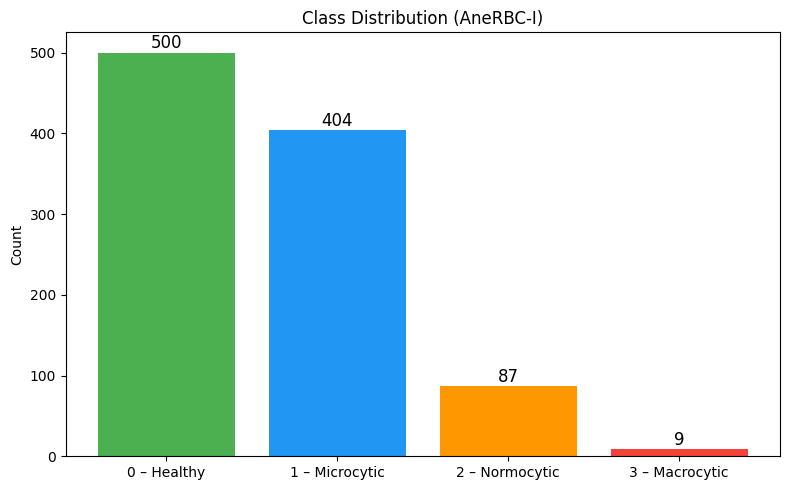

final_class
0    500
1    404
2     87
3      9
Name: count, dtype: int64


In [31]:
class_counts = curated['final_class'].value_counts().sort_index()
class_labels = ['0 – Healthy', '1 – Microcytic', '2 – Normocytic', '3 – Macrocytic']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(class_labels, class_counts.values, color=['#4CAF50', '#2196F3', '#FF9800', '#F44336'])
for bar, count in zip(bars, class_counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
            str(count), ha='center', fontsize=12)
ax.set_ylabel('Count')
ax.set_title('Class Distribution (AneRBC-I)')
plt.tight_layout()
plt.show()

print(class_counts)

### 7b — CBC Feature Distributions per Class (Box Plots)

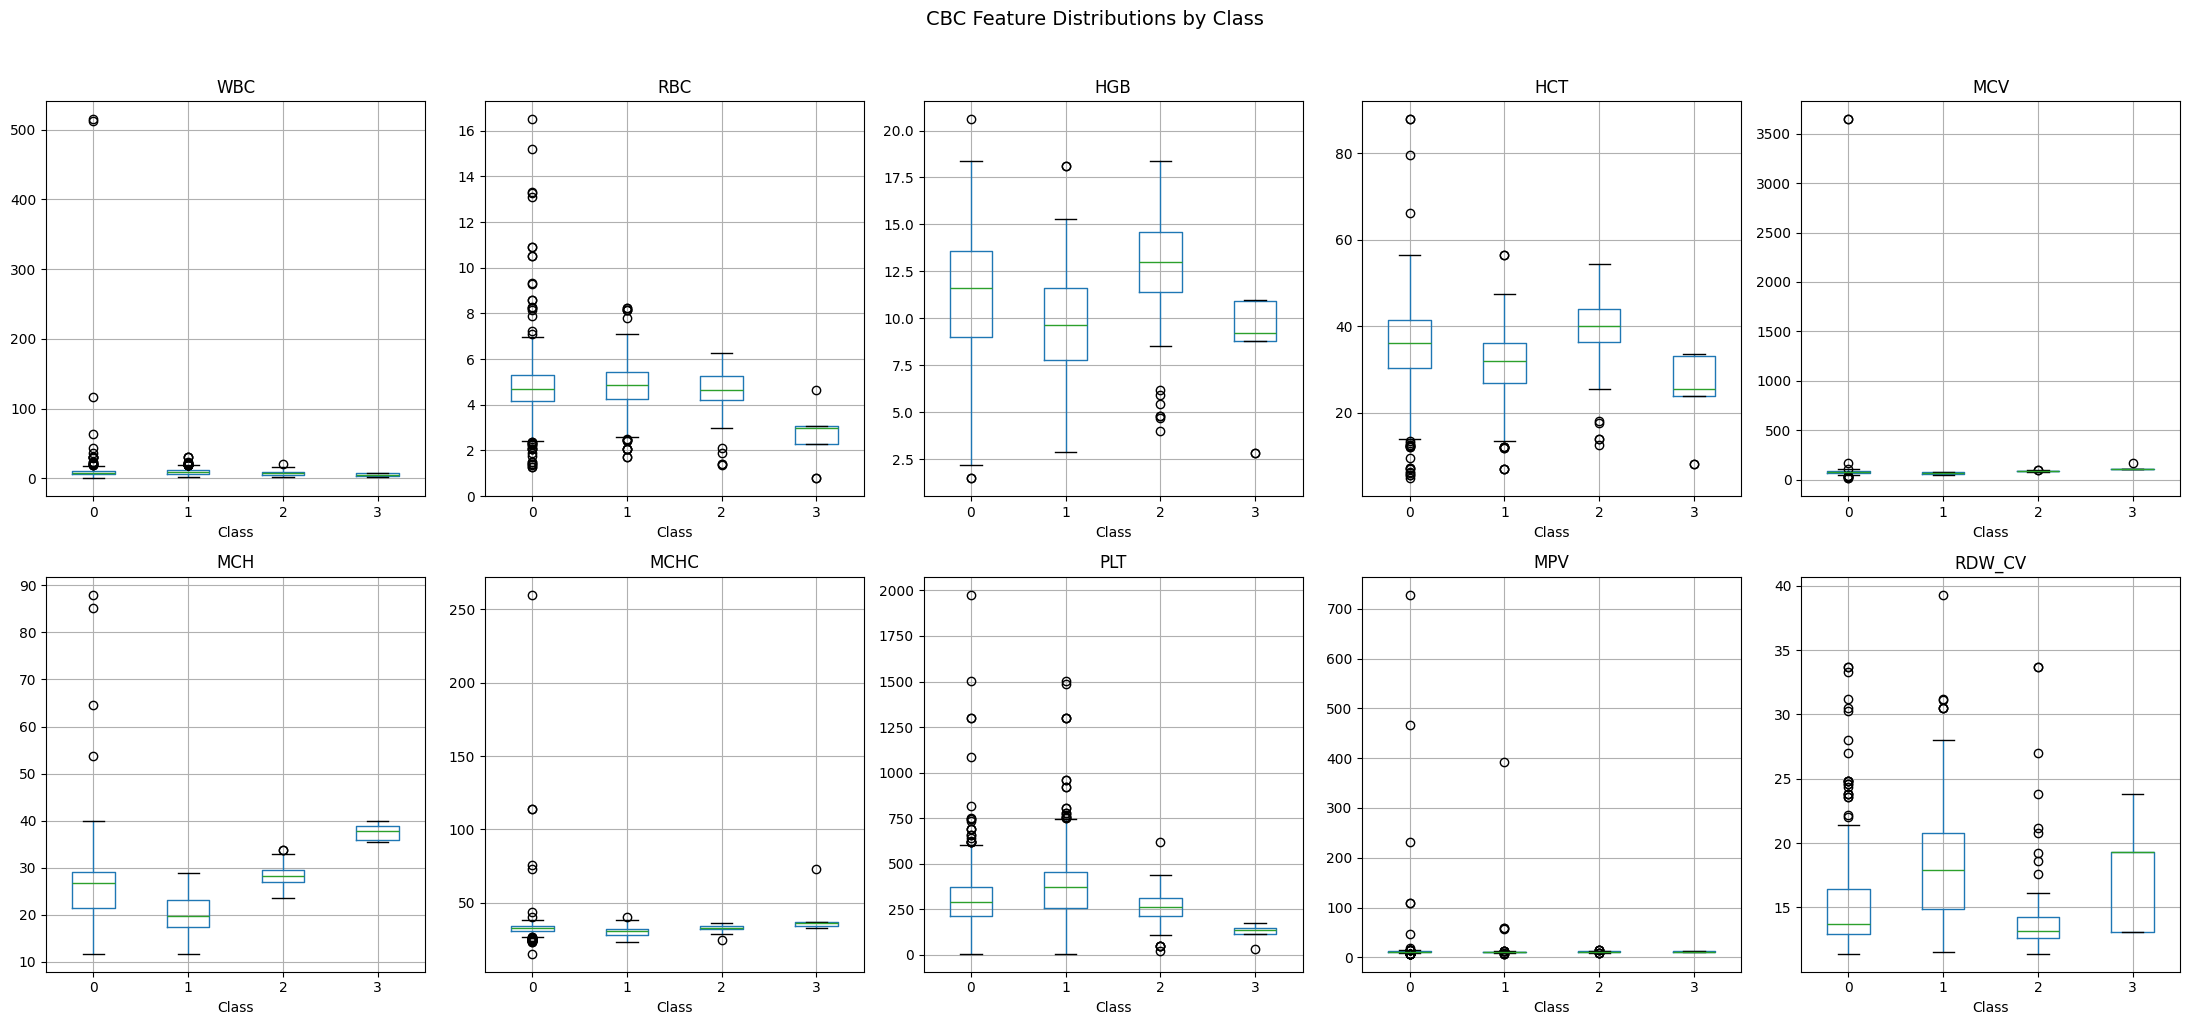

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
for i, feat in enumerate(CBC_FEATURES):
    ax = axes[i // 5, i % 5]
    curated.boxplot(column=feat, by='final_class', ax=ax)
    ax.set_title(feat)
    ax.set_xlabel('Class')
plt.suptitle('CBC Feature Distributions by Class', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 7c — Correlation Heatmap of CBC Features

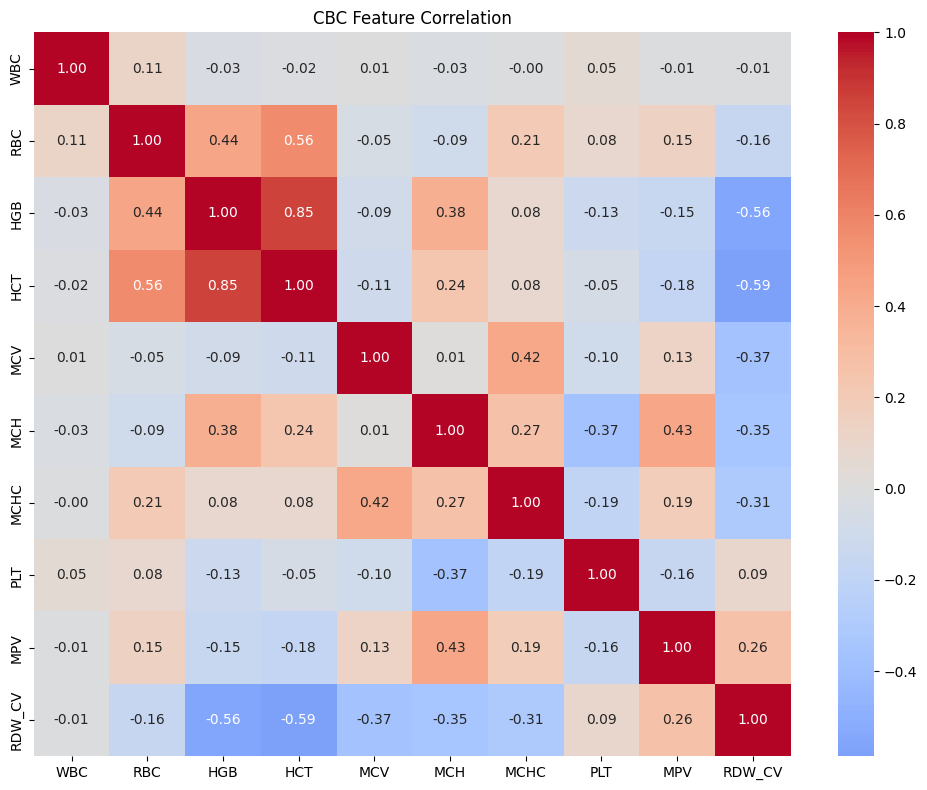

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
corr = curated[CBC_FEATURES].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('CBC Feature Correlation')
plt.tight_layout()
plt.show()

### 7d — Sample Images per Class (grid of 4)

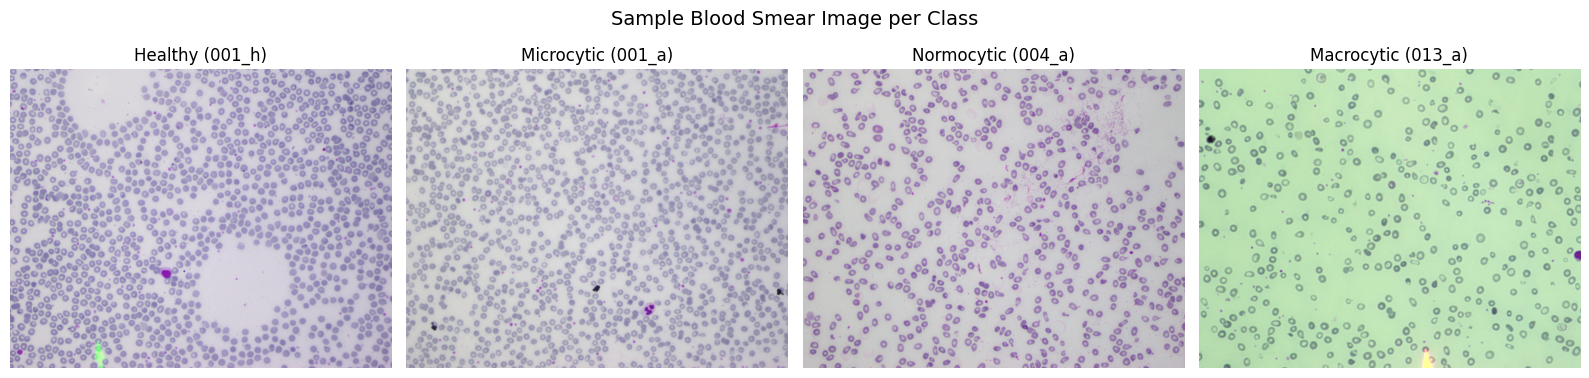

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
class_names = ['Healthy', 'Microcytic', 'Normocytic', 'Macrocytic']
for cls in range(4):
    sample_row = curated[curated['final_class'] == cls].iloc[0]
    img = Image.open(os.path.join(PROJECT_ROOT, sample_row['image_path']))
    axes[cls].imshow(img)
    axes[cls].set_title(f'{class_names[cls]} ({sample_row["patient_id"]})')
    axes[cls].axis('off')
plt.suptitle('Sample Blood Smear Image per Class', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8 — Patient-Level Stratified Split (70 / 15 / 15)

In [35]:
# Since there is a 1:1 patient-to-image mapping, patient_id == row.
# Stratified split on final_class.

train_df, temp_df = train_test_split(
    curated, test_size=0.30, random_state=42, stratify=curated['final_class']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df['final_class']
)

print(f'Train: {len(train_df)}  |  Val: {len(val_df)}  |  Test: {len(test_df)}')
print(f'Total: {len(train_df) + len(val_df) + len(test_df)}')

# Verify no patient overlap
assert len(set(train_df['patient_id']) & set(val_df['patient_id'])) == 0
assert len(set(train_df['patient_id']) & set(test_df['patient_id'])) == 0
assert len(set(val_df['patient_id']) & set(test_df['patient_id'])) == 0
print('No patient overlap between splits.')

Train: 700  |  Val: 150  |  Test: 150
Total: 1000
No patient overlap between splits.


In [36]:
# Class proportions per split
for name, split in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    dist = split['final_class'].value_counts().sort_index()
    pct = (dist / len(split) * 100).round(1)
    print(f'{name} ({len(split)}):')
    for c in sorted(dist.index):
        print(f'  Class {c}: {dist[c]:>4d}  ({pct[c]}%)')
    print()

Train (700):
  Class 0:  350  (50.0%)
  Class 1:  283  (40.4%)
  Class 2:   61  (8.7%)
  Class 3:    6  (0.9%)

Val (150):
  Class 0:   75  (50.0%)
  Class 1:   60  (40.0%)
  Class 2:   13  (8.7%)
  Class 3:    2  (1.3%)

Test (150):
  Class 0:   75  (50.0%)
  Class 1:   61  (40.7%)
  Class 2:   13  (8.7%)
  Class 3:    1  (0.7%)



### Step 8b — Median Imputation (training-set-only statistics)

In [37]:
# Compute medians on training set only
impute_features = ['MPV', 'RDW_CV']  # known to have missing values
train_medians = train_df[impute_features].median()
print('Training-set medians for imputation:')
print(train_medians)

# Apply to all splits
train_df = train_df.copy()
val_df   = val_df.copy()
test_df  = test_df.copy()

for feat in impute_features:
    med = train_medians[feat]
    train_df[feat] = train_df[feat].fillna(med)
    val_df[feat]   = val_df[feat].fillna(med)
    test_df[feat]  = test_df[feat].fillna(med)

# Confirm no missing values remain
for name, split in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    nulls = split[CBC_FEATURES].isnull().sum().sum()
    print(f'{name} missing values after imputation: {nulls}')

Training-set medians for imputation:
MPV       10.9
RDW_CV    14.4
dtype: float64
Train missing values after imputation: 14
Val missing values after imputation: 2
Test missing values after imputation: 0


### Step 8c — Save Split CSVs

In [38]:
train_df.to_csv(os.path.join(TRANSFORMED, 'train_split.csv'), index=False)
val_df.to_csv(os.path.join(TRANSFORMED, 'val_split.csv'), index=False)
test_df.to_csv(os.path.join(TRANSFORMED, 'test_split.csv'), index=False)
print('Saved train_split.csv, val_split.csv, test_split.csv')

Saved train_split.csv, val_split.csv, test_split.csv


## Step 9 — Compute Class Weights

In [20]:
sys.path.insert(0, os.path.abspath(NOTEBOOK_DIR))
from utils.training import compute_class_weights

class_weights = compute_class_weights(train_df['final_class'].values)
class_names = ['Healthy', 'Microcytic', 'Normocytic', 'Macrocytic']
print('Class weights for CrossEntropyLoss:')
for i, name in enumerate(class_names):
    print(f'  {name} (class {i}): {class_weights[i]:.4f}')

# Save for Notebook 2
torch.save(class_weights, os.path.join(TRANSFORMED, 'class_weights.pt'))
print('\nSaved class_weights.pt')

Class weights for CrossEntropyLoss:
  Healthy (class 0): 0.5000
  Microcytic (class 1): 0.6184
  Normocytic (class 2): 2.8689
  Macrocytic (class 3): 29.1667

Saved class_weights.pt


## Verification Checklist

- [ ] `curated_dataset.csv` has 1000 rows
- [ ] All `image_path` values resolve to real files on disk
- [ ] All `processed_image_path` `.pt` files exist and are loadable
- [ ] No NaN in `final_class`
- [ ] Split proportions are ~70/15/15
- [ ] No patient appears in multiple splits
- [ ] Class proportions preserved across splits
- [ ] Missing values imputed using training-set-only statistics

In [21]:
# Final verification
print('=== VERIFICATION ===')
print(f'Curated rows      : {len(curated)} (expect 1000)')
print(f'NaN in final_class: {curated["final_class"].isnull().sum()}')

pt_files = [os.path.join(PROJECT_ROOT, p) for p in curated['processed_image_path']]
all_pt_exist = all(os.path.exists(f) for f in pt_files)
print(f'All .pt files exist: {all_pt_exist}')

# Load one to verify offline tensor properties
sample_tensor = torch.load(pt_files[0], weights_only=True)
print(f'Sample .pt shape  : {sample_tensor.shape}  (expect torch.Size([3, 256, 256]))')
print(f'Sample value range: [{sample_tensor.min():.3f}, {sample_tensor.max():.3f}]  (expect ~[0, 1])')

total = len(train_df) + len(val_df) + len(test_df)
print(f'\nSplit sizes: {len(train_df)}/{len(val_df)}/{len(test_df)} = {total}')
print(f'Split %    : {len(train_df)/total*100:.1f}/{len(val_df)/total*100:.1f}/{len(test_df)/total*100:.1f}')
print('\nDone!')

=== VERIFICATION ===
Curated rows      : 1000 (expect 1000)
NaN in final_class: 0
All .pt files exist: True
Sample .pt shape  : torch.Size([3, 256, 326])  (expect torch.Size([3, 256, 256]))
Sample value range: [0.071, 0.878]  (expect ~[0, 1])

Split sizes: 700/150/150 = 1000
Split %    : 70.0/15.0/15.0

Done!
